In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as nnf
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

c:\Users\Nassim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Nassim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Nassim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Nassim\AppData\Local\Temp\ipykernel_1088\1160388593.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\Nassim\AppData\Local\Temp\ipykernel_1088\1160388593.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


# Preprocessing learning data

In [2]:
path_imgs = './data/portraits/'
path_imgs_edited = './data/Player_output/Photoshop/'

list_imgs = os.listdir(path_imgs)
list_imgs_edited = os.listdir(path_imgs_edited)

d_imgs = dict() 
d_edited_names = dict()

for img_name in list_imgs : 
    d_imgs[img_name] = np.array(Image.open(path_imgs + img_name))
    
    list_imgs_name_edited = [x for x in list_imgs_edited if x.startswith(img_name[:-4] + "_")]
    d_edited_names[img_name] = list_imgs_name_edited

    for img_name_edited in list_imgs_name_edited : 
        d_imgs[img_name_edited] = np.array(Image.open(path_imgs_edited + img_name_edited))
    



In [3]:
from PIL import Image 
import PIL

save_pair_folder = "./data/pair_tmp/"

dataset = []
for img in d_edited_names : 
    for edited_img in d_edited_names[img] : 
        d = np.hstack((d_imgs[img], d_imgs[edited_img]))
        dataset.append(d)
        i = Image.fromarray(d)
        i.save(save_pair_folder + edited_img[:-4] + "_pair.jpg")

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
#Code to generate dataset with cropped images

# Loading data / functions

In [2]:
path_pair_img = 'data/photoshoptest'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


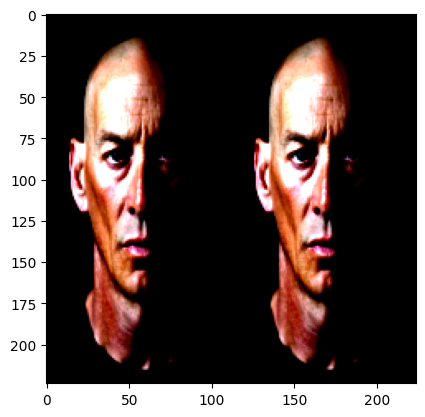

In [3]:
image = dataset[0][0]
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    #Used to calculate the confusion matrix
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:

            Xd, yd = X.to(device), y.to(device)
            pred = model(Xd)
            
            test_loss += loss_fn(pred, yd).item()
            correct += (pred.argmax(1) == yd).type(torch.float).sum().item()
            
            
            y_pred.extend(pred.argmax(1).data.cpu().numpy())
            y_true.extend(y.data.cpu().numpy())

        

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()
    plt.xticks(rotation = 45) 
    plt.show()
    

# Training

In [ ]:
epochs = 20

for i in range(5):
    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
    print("Done!")



In [85]:
torch.save(model.state_dict(), "./models/model")

# Testing phase

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.567047 



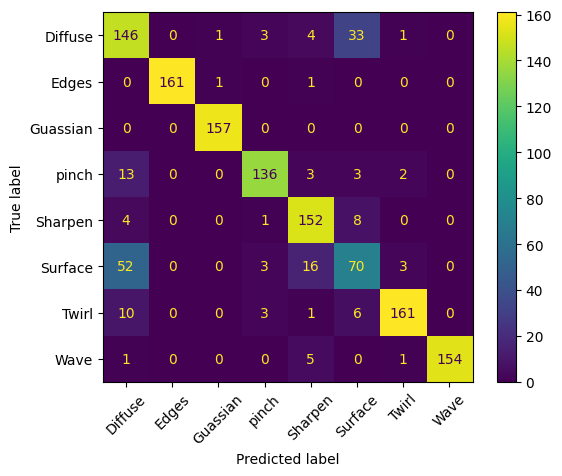

In [10]:
model = LeNet().to(device)
model.load_state_dict(torch.load("./models/model"))
model.eval()
loss_fn = nn.CrossEntropyLoss()

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=100,
    shuffle=False
)

test(test_dataloader, model, loss_fn)

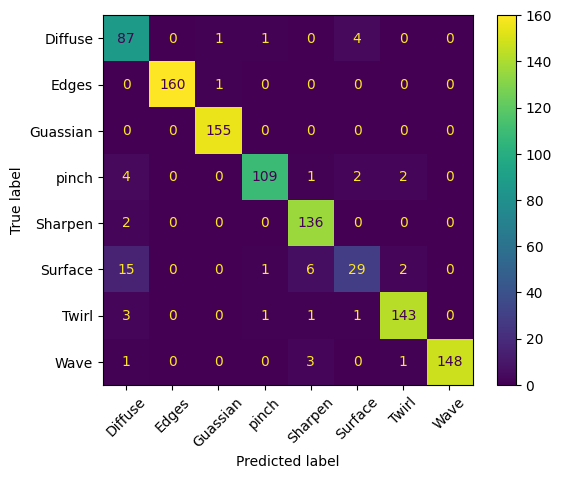

In [12]:
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.90
indices = y_pred.max(1) > seuil
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]

conf_matrix = confusion_matrix(y_true, y_pred)
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()

### R & D

In [50]:
dataset = datasets.ImageFolder(root=path_pair_img)

In [11]:
import cv2
import numpy as np

def find_edited_areas(image1, image2, threshold=30, min_area=1000):
    # Compute the absolute difference between the two images
    diff_image = cv2.absdiff(image1, image2)

    # Convert the difference image to grayscale
    gray_diff = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to obtain a binary image
    _, thresholded_diff = cv2.threshold(gray_diff, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

    # Calculate bounding boxes around the edited areas
    bounding_boxes = [cv2.boundingRect(contour) for contour in filtered_contours]

    return bounding_boxes


def bounding_box_from_points(points):
    x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

def find_bb(img_org, img_edt) : 
    # Load the two images
    image1 = img_org
    image2 = img_edt

    save_folder = "../data/pair_tmp/"

    # Find the bounding boxes around the edited areas, with a minimum area of 1000 pixels
    edited_areas = find_edited_areas(image1, image2, min_area=10)

    # Define the scaling factor (1.0 means no scaling)
    scale_factor = 1

    # Used for the second approach (define the bounding box of smaller bounding boxes)
    min_x = min_y = 100000
    max_x = max_y = 0

    if len(edited_areas) > 0:
        for i, (x, y, w, h) in enumerate(edited_areas):
            # Calculate the scaled dimensions for cropping
            scaled_w = int(w * scale_factor)
            scaled_h = int(h * scale_factor)
            scaled_x = max(0, int(x - (scaled_w - w) / 2))
            scaled_y = max(0, int(y - (scaled_h - h) / 2))

            # Crop the selected area
            # cropped_image1 = image1[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            # cropped_image2 = image2[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            
            # final_image = np.hstack((cropped_image1, cropped_image2))
            # cv2.imwrite(save_folder + "final_pair_" + str(i) + ".jpg", final_image)

            if (min_x > scaled_x) : min_x = scaled_x
            if (min_y > scaled_y) : min_y = scaled_y
            if (max_x < scaled_x + scaled_w) : max_x = scaled_x + scaled_w 
            if (max_y < scaled_y + scaled_h) : max_y = scaled_y + scaled_h 

            # Visualize the bounding box for verification
            # cv2.rectangle(image2, (scaled_x, scaled_y), (scaled_x + scaled_w, scaled_y + scaled_h), (0, 255, 0), 2)
            # print("Rectangle N° ", i, " coord (w, h, x, y) : (",  scaled_w, scaled_h, scaled_x, scaled_y, " )")


    else:
        return np.hstack((image1, image2))

    #Second approche : Bounding box sur toutes les bounding box
    # cv2.rectangle(image2, (min_x, min_y), (max_x, max_y), (0,0,255), 2)
    cropped_image1 = image1[min_y:max_y, min_x:max_x]
    cropped_image2 = image2[min_y:max_y, min_x:max_x]      
    final_image = np.hstack((cropped_image1, cropped_image2))
    
    return final_image
    # cv2.imwrite(save_folder + "final_pair_bb" ".jpg", final_image)

    # Display the image with bounding boxes (optional)
    # cv2.imshow("Cropped around the edits", image2)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'cv2'

In [89]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use your normalization values
])

y_pred = []
y_true = []

cpt = 0
for img, y  in dataset :
    print(cpt)
    cpt += 1
    y_true.append(y)
    img_org, img_edt = np.hsplit(np.array(img), 2)
    final_img = find_bb(img_org, img_edt)
        
    image_tensor = transform(Image.fromarray(final_img)).unsqueeze(0)
    image_tensor = image_tensor.cuda()

    with torch.no_grad() : 
        output = model(image_tensor)

    _, predicted_class = torch.max(output, 1)

    y_pred.append(predicted_class.item())
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

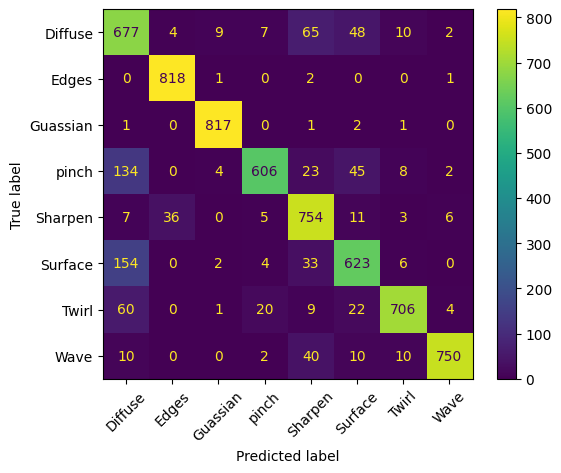

In [90]:
conf_matrix = confusion_matrix(y_true, y_pred)
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()

# TEST UNITAIRE

In [13]:
from PIL import Image 
import PIL
import numpy as np

path_imgs = './data/portraits/'
path_imgs_edited = './data/Player_output/Photoshop/'

img = np.array(Image.open('./data/pair_tmp/photo-1621849400072-f554417f7051n.jpg'))
# img = img[:150, :200, :]

img_edited = np.array(Image.open('./data/pair_tmp/photo-1621849400072-f554417f7051.jpg'))
# img_edited = img_edited[:150, :200, :]


save_pair_folder = "./data/pair_tmp/"

d = np.hstack((img, img_edited))

i = Image.fromarray(d)
i.save(save_pair_folder + "custom_plant_" + "_pair.jpg")
# i.save(save_pair_folder + edited_img[:-4] + "_cropped.jpg")


FileNotFoundError: [Errno 2] No such file or directory: './data/pair_tmp/photo-1621849400072-f554417f7051n.jpg'

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use your normalization values
])

i = Image.open("./data/pair_tmp/final_pair_1.jpg")
image_tensor = transform(i).unsqueeze(0)
image_tensor = image_tensor.cuda()

with torch.no_grad() : 
    output = model(image_tensor)

_, predicted_class = torch.max(output, 1)

probas = nnf.softmax(output, dim=1)

print("predicted class : ", predicted_class.item())
print("Proba de prédiction : ", probas[0, predicted_class.item()].item())


predicted class :  1
Proba de prédiction :  1.0
